This file takes the merged dataframe of ACS Data and NPI information for EDA


In [1]:
### Import Libraries 
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import pgeocode as pg       #might not need here
import censusgeocode as cg  #might not need here
import matplotlib.patches as mpatches

from shapely.geometry import Point
import random

import matplotlib.colors as mcolors
import matplotlib.cm as cm

import plotly.express as px

import dash
from dash import dcc, html, Output, Input
import warnings

In [2]:
# Ignore all warnings
warnings.simplefilter("ignore")

In [3]:
### Import mergedTable
mergedTable = pd.read_pickle('mergedTableAllCounties.pkl')
mergedTable.head()

,County,Provider Count,County Name,householdIncomeBins,hsDegreeBins,marriedBins,cohabitingBins,maleHouseholderBins,femaleHouseholderBins,neverMarriedBins,...,separatedBins,widowedBins,divorcedBins,nativeBornBins,foreignBornBins,civilVetBins,belowPovertyBins,atOrAbovePovertyBins,65andOverBins,75andOverBins
0,08001,11.0,Adams County,Very High,Very Low,Medium,Very High,Low,Medium,Very High,...,Very High,Very Low,Low,Very Low,Very High,Low,Low,High,Very Low,Very Low
1,08003,1.0,Alamosa County,Very Low,Low,Very Low,High,Very High,High,Very High,...,Low,Medium,Very High,Medium,Medium,Very Low,Very High,Very Low,Very Low,Low
2,08005,65.0,Arapahoe County,Very High,Medium,Low,High,Low,High,Very High,...,High,Low,Medium,Very Low,Very High,Medium,Low,High,Very Low,Low
3,08007,NaN,Archuleta County,Medium,High,Very High,Very Low,Very Low,Low,Very Low,...,Very Low,Medium,Very Low,High,Low,Very High,Low,High,Very High,High
4,08009,1.0,Baca County,Very Low,Very Low,Very Low,High,High,Very High,Low,...,Medium,Very High,Medium,Medium,Medium,Low,Very High,Very Low,High,Very High


In [4]:
### Import Census Tract Boundaries
tracts = gpd.read_file('Colorado_County_Boundaries.geojson')
# tracts

In [5]:
tracts = tracts.rename(columns={'US_FIPS': 'County', 'FULL': 'County Name'})
tracts = tracts[['County', 'County Name', 'geometry']]
tracts

,County,County Name,geometry
0,08069,Larimer County,"POLYGON ((-105.05673 40.34929, -105.05664 40.3..."
1,08071,Las Animas County,"POLYGON ((-104.14319 37.75834, -104.14408 37.7..."
2,08043,Fremont County,"POLYGON ((-105.3689 38.25941, -105.36889 38.25..."
3,08051,Gunnison County,"POLYGON ((-106.7997 38.97966, -106.80041 38.97..."
4,08021,Conejos County,"POLYGON ((-106.14888 37.40111, -106.15066 37.4..."
...,...,...,...
59,08031,Denver County,"MULTIPOLYGON (((-104.93414 39.70015, -104.9341..."
60,08093,Park County,"POLYGON ((-105.97509 38.9101, -105.97501 38.91..."
61,08041,El Paso County,"POLYGON ((-104.86403 39.1298, -104.8645 39.129..."
62,08005,Arapahoe County,"MULTIPOLYGON (((-104.89916 39.62414, -104.8989..."


In [6]:
### Add Census Boundaries to mergedTable
mergedTableBounds = pd.merge(tracts, mergedTable, on = ['County', 'County Name'], how = 'left')
mergedTableBounds.head() 

,County,County Name,geometry,Provider Count,householdIncomeBins,hsDegreeBins,marriedBins,cohabitingBins,maleHouseholderBins,femaleHouseholderBins,...,separatedBins,widowedBins,divorcedBins,nativeBornBins,foreignBornBins,civilVetBins,belowPovertyBins,atOrAbovePovertyBins,65andOverBins,75andOverBins
0,08069,Larimer County,"POLYGON ((-105.05673 40.34929, -105.05664 40.3...",14.0,High,Very High,Medium,Very High,Very Low,Medium,...,Low,Low,Very Low,Medium,Medium,Low,Medium,Medium,Low,Low
1,08071,Las Animas County,"POLYGON ((-104.14319 37.75834, -104.14408 37.7...",1.0,Very Low,Low,Very Low,Very High,High,High,...,High,High,High,High,Low,High,Very High,Very Low,Very High,Very High
2,08043,Fremont County,"POLYGON ((-105.3689 38.25941, -105.36889 38.25...",2.0,Low,Low,Low,High,Low,High,...,High,Medium,Very High,Very High,Very Low,Very High,High,Low,High,High
3,08051,Gunnison County,"POLYGON ((-106.7997 38.97966, -106.80041 38.97...",NaN,High,Very High,Low,Very High,Very High,Very Low,...,Very Low,Very Low,Very Low,High,Low,Very Low,High,Low,Very Low,Very Low
4,08021,Conejos County,"POLYGON ((-106.14888 37.40111, -106.15066 37.4...",NaN,Very Low,Low,Low,Low,High,High,...,Very High,Very High,Low,Medium,Medium,Medium,High,Low,Medium,Medium


Update columns for Correlation Mapping

In [7]:
corrDF = mergedTableBounds.copy()
corrDF = corrDF.drop(columns=['County', 'County Name', 'geometry'])

ordinalMap = {'Very Low': 1, 'Low': 2, 'Medium': 3, 'High': 4, 'Very High': 5}

binColumns = [col for col in corrDF.columns if col.endswith('Bins')]
for col in binColumns:
    corrDF[col] = corrDF[col].replace(ordinalMap).astype('float')

corrDF = corrDF.dropna()

In [8]:
corrDF
##Output for ML references
corrDF.to_pickle('corrDF.pkl')

Correlation Map

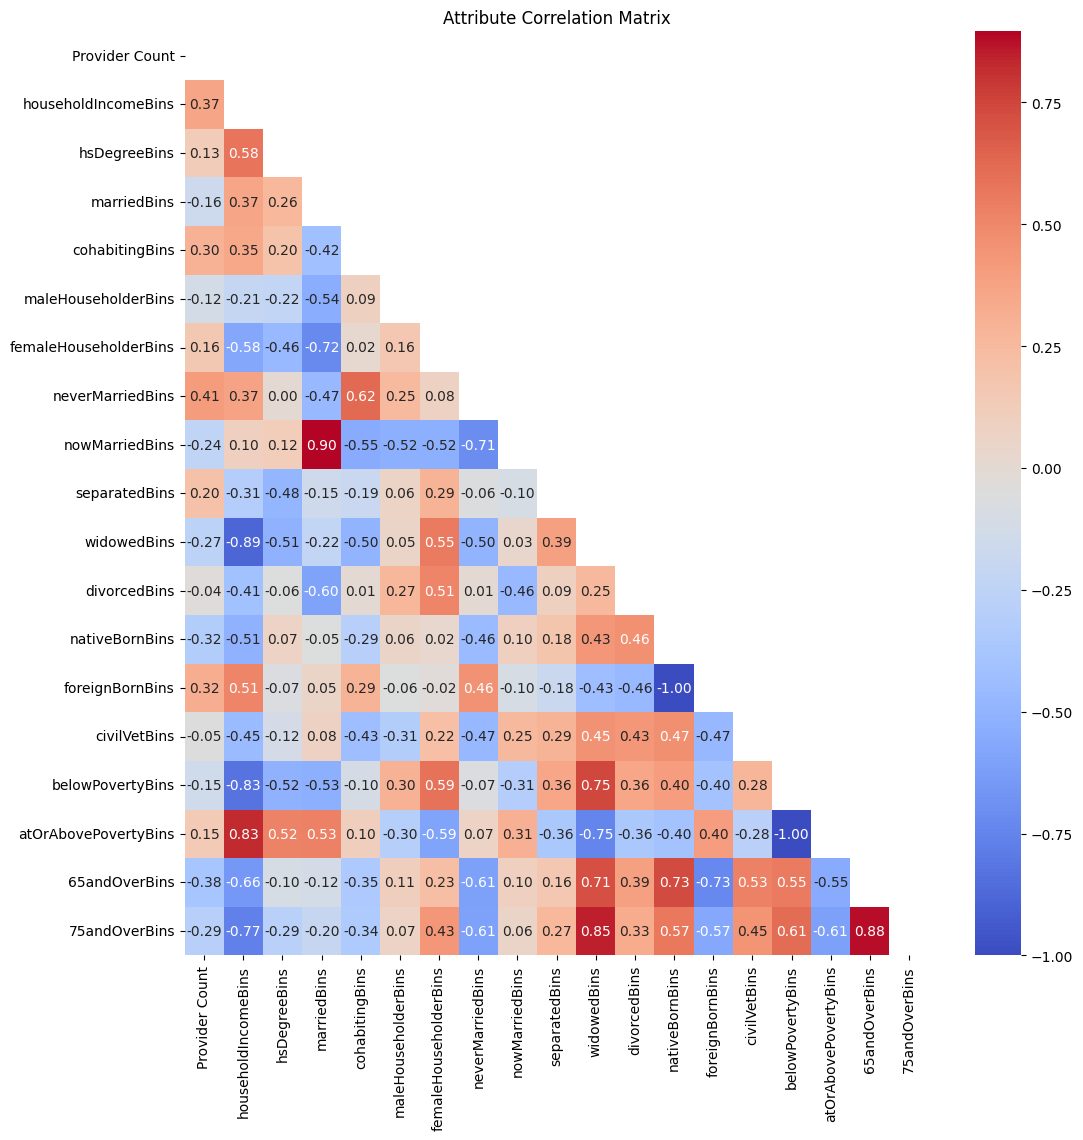

In [9]:
corrMatrix = corrDF.corr()
mask = np.triu(np.ones_like(corrMatrix, dtype=bool))
plt.figure(figsize=(12,12))
sns.heatmap(corrMatrix, mask = mask, annot = True, cmap = 'coolwarm', fmt = ".2f")
plt.title('Attribute Correlation Matrix')
plt.show()

Correlation Matrix

In [10]:
corrMatrix

,Provider Count,householdIncomeBins,hsDegreeBins,marriedBins,cohabitingBins,maleHouseholderBins,femaleHouseholderBins,neverMarriedBins,nowMarriedBins,separatedBins,widowedBins,divorcedBins,nativeBornBins,foreignBornBins,civilVetBins,belowPovertyBins,atOrAbovePovertyBins,65andOverBins,75andOverBins
Provider Count,1.000000,0.368417,0.128929,-0.161074,0.300894,-0.122393,0.159351,0.409261,-0.243538,0.202389,-0.265508,-0.036999,-0.318244,0.318244,-0.045879,-0.146198,0.146198,-0.379619,-0.293700
householdIncomeBins,0.368417,1.000000,0.579003,0.369755,0.351782,-0.213958,-0.576071,0.370707,0.096917,-0.305398,-0.886205,-0.411897,-0.511296,0.511296,-0.452367,-0.827873,0.827873,-0.656133,-0.769063
hsDegreeBins,0.128929,0.579003,1.000000,0.263016,0.195186,-0.222635,-0.459761,0.004872,0.122973,-0.481955,-0.511359,-0.056501,0.069613,-0.069613,-0.116639,-0.518684,0.518684,-0.097831,-0.287830
marriedBins,-0.161074,0.369755,0.263016,1.000000,-0.421503,-0.537963,-0.722847,-0.466387,0.895547,-0.153618,-0.223695,-0.597130,-0.052894,0.052894,0.076964,-0.526478,0.526478,-0.119822,-0.204413
cohabitingBins,0.300894,0.351782,0.195186,-0.421503,1.000000,0.091463,0.017748,0.623184,-0.552404,-0.191729,-0.496796,0.005076,-0.291427,0.291427,-0.434786,-0.104860,0.104860,-0.348728,-0.338290
maleHouseholderBins,-0.122393,-0.213958,-0.222635,-0.537963,0.091463,1.000000,0.163452,0.250062,-0.519787,0.059597,0.052823,0.269309,0.058345,-0.058345,-0.313263,0.301229,-0.301229,0.106891,0.071065
femaleHouseholderBins,0.159351,-0.576071,-0.459761,-0.722847,0.017748,0.163452,1.000000,0.082294,-0.522412,0.292846,0.551858,0.514706,0.023386,-0.023386,0.215658,0.586618,-0.586618,0.225362,0.429812
neverMarriedBins,0.409261,0.370707,0.004872,-0.466387,0.623184,0.250062,0.082294,1.000000,-0.706306,-0.060613,-0.502481,0.005349,-0.458642,0.458642,-0.473093,-0.067328,0.067328,-0.608762,-0.606031
nowMarriedBins,-0.243538,0.096917,0.122973,0.895547,-0.552404,-0.519787,-0.522412,-0.706306,1.000000,-0.102493,0.031041,-0.460336,0.097049,-0.097049,0.253080,-0.307837,0.307837,0.097710,0.055307
separatedBins,0.202389,-0.305398,-0.481955,-0.153618,-0.191729,0.059597,0.292846,-0.060613,-0.102493,1.000000,0.386532,0.090819,0.180924,-0.180924,0.290453,0.356794,-0.356794,0.163032,0.266157


In [11]:
### I don't want to see correlations between items from the same table
excludedGroups = [
    {'marriedBins', 'cohabitingBins', 'maleHouseholderBins', 'femaleHouseholderBins', 'neverMarriedBins', 'nowMarriedBins',	'separatedBins', 'widowedBins', 'divorcedBins'},
	{'nativeBornBins', 'foreignBornBins'},
	{'belowPovertyBins', 'atOrAbovePovertyBins'},
	{'65andOverBins', '75andOverBins'}
]

def excludedPairs(col1, col2):
    for group in excludedGroups:
        if col1 in group and col2 in group:
            return True
    return False


In [12]:
### Build correlation DF
corrPairs = corrMatrix.unstack().reset_index()
corrPairs.columns = ['Var 1', 'Var 2', 'Correlation']
corrPairs = corrPairs[corrPairs['Var 1'] != corrPairs['Var 2']]

## Avoid duplicates like (A,B) and (B,A) 
corrPairs['Pair'] = corrPairs.apply(lambda row: tuple(sorted([row['Var 1'], row['Var 2']])), axis=1)
corrPairs = corrPairs.drop_duplicates('Pair')

## Fliter out excluded pairs
corrPairs = corrPairs[~corrPairs['Pair'].apply(lambda x: excludedPairs(*x))]

## Calculate abs and sort
corrPairs['AbsCorr'] = corrPairs['Correlation'].abs()
sortedCorrPairs = corrPairs.sort_values(by = 'AbsCorr', ascending=False).round(2)

sortedCorrPairs.head(75)

,Var 1,Var 2,Correlation,Pair,AbsCorr
29,householdIncomeBins,widowedBins,-0.89,"(householdIncomeBins, widowedBins)",0.89
208,widowedBins,75andOverBins,0.85,"(75andOverBins, widowedBins)",0.85
34,householdIncomeBins,belowPovertyBins,-0.83,"(belowPovertyBins, householdIncomeBins)",0.83
35,householdIncomeBins,atOrAbovePovertyBins,0.83,"(atOrAbovePovertyBins, householdIncomeBins)",0.83
37,householdIncomeBins,75andOverBins,-0.77,"(75andOverBins, householdIncomeBins)",0.77
...,...,...,...,...,...
167,nowMarriedBins,belowPovertyBins,-0.31,"(belowPovertyBins, nowMarriedBins)",0.31
168,nowMarriedBins,atOrAbovePovertyBins,0.31,"(atOrAbovePovertyBins, nowMarriedBins)",0.31
28,householdIncomeBins,separatedBins,-0.31,"(householdIncomeBins, separatedBins)",0.31
110,maleHouseholderBins,belowPovertyBins,0.30,"(belowPovertyBins, maleHouseholderBins)",0.30


### Mapping Provider Count by ACS Measure and Alzheimer's and Dementia (AD) Rates

In [13]:
# for any Provider Count that has NA -- this should be 0 instead
mergedTableBounds['Provider Count'] = mergedTableBounds['Provider Count'].fillna(0).astype(int)

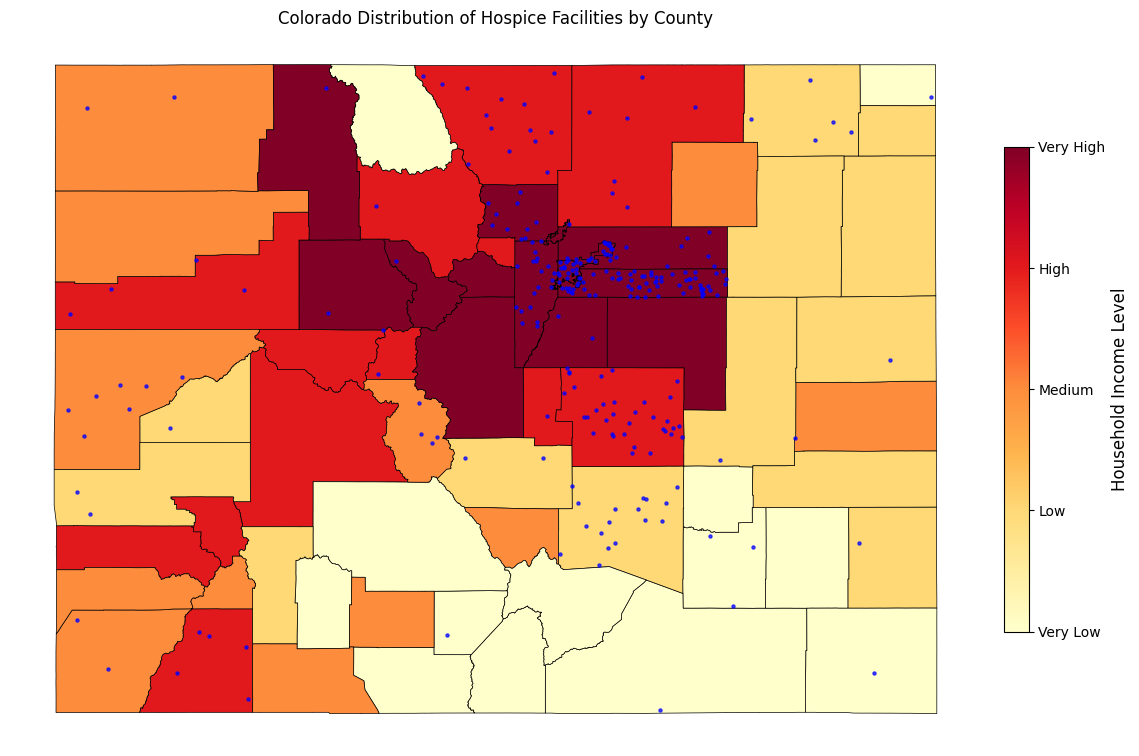

In [14]:
# if Provider Count is NaN, then 0
mergedTableBounds['Provider Count'] = mergedTableBounds['Provider Count'].fillna(0).astype(int)

# Function to generate N random points within a polygon
def generate_random_points_in_polygon(polygon, num_points):
    points = []
    minx, miny, maxx, maxy = polygon.bounds
    while len(points) < num_points:
        random_point = Point(random.uniform(minx, maxx), random.uniform(miny, maxy))
        if polygon.contains(random_point):
            points.append(random_point)
    return points

# Copy your original GeoDataFrame (assume it's called gdf)
provider_points = []

# For each county, generate one dot per provider randomly within the polygon
for _, row in mergedTableBounds.iterrows():
    polygon = row.geometry
    count = int(row['Provider Count'])
    if count > 0:
        points = generate_random_points_in_polygon(polygon, count)
        provider_points.extend(points)

# Create a GeoDataFrame of all provider dots
provider_gdf = gpd.GeoDataFrame(geometry=provider_points, crs=mergedTableBounds.crs)

fig, ax = plt.subplots(figsize=(12, 10))

# Define colormap and normalize values
cmap = plt.cm.YlOrRd
norm = mcolors.Normalize(vmin=mergedTableBounds['householdIncomeBins'].astype('category').cat.codes.min(),
                         vmax=mergedTableBounds['householdIncomeBins'].astype('category').cat.codes.max())

# Convert category to numeric code for mapping
mergedTableBounds['acs_code'] = mergedTableBounds['householdIncomeBins'].astype('category').cat.codes

# Plot shaded counties
mergedTableBounds.plot(
    column='acs_code',
    cmap=cmap,
    edgecolor='black',
    linewidth=0.5,
    ax=ax
)

# Plot provider dots (same as before)
provider_gdf.plot(ax=ax, color='blue', markersize=5, alpha=0.7)

# Create colorbar/legend
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

cbar = fig.colorbar(sm, ax=ax, orientation="vertical", shrink=0.5, pad=0.02)
cbar.set_label("Household Income Level", fontsize=12)
cbar.ax.tick_params(labelsize=10)
cbar.ax.yaxis.set_ticks_position('right')
cbar.ax.yaxis.set_label_position('right')

# Optional: use original category labels for ticks
tick_labels = mergedTableBounds['householdIncomeBins'].astype('category').cat.categories.tolist()
cbar.set_ticks(range(len(tick_labels)))
cbar.set_ticklabels(tick_labels)

# Clean up
plt.title("Colorado Distribution of Hospice Facilities by County")
plt.axis('off')
plt.tight_layout()
plt.show()

In [15]:
# merge table with AD rates:
df_alz = pd.read_pickle('df_alzheimers.pkl')
df_alz['County Name Short'] = df_alz['County']
mergedTableBounds['County Name Short']  = mergedTableBounds['County Name'].str.replace(' County', '', regex=False)

mergedTable_alz = pd.merge(mergedTableBounds, df_alz, on = 'County Name Short', how = 'outer')

mergedTable_alz.head()

,County_x,County Name,geometry,Provider Count,householdIncomeBins,hsDegreeBins,marriedBins,cohabitingBins,maleHouseholderBins,femaleHouseholderBins,...,belowPovertyBins,atOrAbovePovertyBins,65andOverBins,75andOverBins,acs_code,County Name Short,County_y,Total Pop. Age 65+,AD Cases Age 65+,AD Prevalence (Age 65+)
0,08001,Adams County,"POLYGON ((-104.5825 39.73964, -104.58233 39.73...",11,Very High,Very Low,Medium,Very High,Low,Medium,...,Low,High,Very Low,Very Low,4,Adams,Adams,"57,400","6,100",10.7%
1,08003,Alamosa County,"POLYGON ((-106.03931 37.57699, -106.03931 37.5...",1,Very Low,Low,Very Low,High,Very High,High,...,Very High,Very Low,Very Low,Low,0,Alamosa,Alamosa,"2,400",300,11.5%
2,08005,Arapahoe County,"MULTIPOLYGON (((-104.89916 39.62414, -104.8989...",65,Very High,Medium,Low,High,Low,High,...,Low,High,Very Low,Low,4,Arapahoe,Arapahoe,"92,000","9,800",10.6%
3,08007,Archuleta County,"POLYGON ((-107.25498 37.00001, -107.25489 37.0...",0,Medium,High,Very High,Very Low,Very Low,Low,...,Low,High,Very High,High,2,Archuleta,Archuleta,"3,900",300,8.8%
4,08009,Baca County,"POLYGON ((-102.27024 36.99433, -102.27013 36.9...",1,Very Low,Very Low,Very Low,High,High,Very High,...,Very High,Very Low,High,Very High,0,Baca,Baca,900,100,12.5%


In [16]:
# Get min and max of AD prevalence for easier mapping
mergedTable_alz['AD Prevalence (Age 65+)'] = mergedTable_alz['AD Prevalence (Age 65+)'].str.rstrip('%').astype(float)

min_AD_prev = mergedTable_alz['AD Prevalence (Age 65+)'].min()
max_AD_prev = mergedTable_alz['AD Prevalence (Age 65+)'].max()
print('min AD prevalence: ', min_AD_prev, '\n', 'max AD prevalence: ', max_AD_prev)


min AD prevalence:  6.9 
 max AD prevalence:  13.6


### Final Dashboard of Provider Count and Sociodemographic Measures by County

In [17]:
# with AD prevalence
import dash
from dash import dcc, html, Output, Input
import plotly.graph_objects as go
import geopandas as gpd
import pandas as pd
import json
import random
from shapely.geometry import Point
from urllib.request import urlopen

# Load GeoJSON
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)

# Load your GeoDataFrame (replace this with your own file or source)
# mergedTable_alz = gpd.read_file("your_data_file.geojson")

# Ensure FIPS codes are strings
mergedTable_alz['County_x'] = mergedTable_alz['County_x'].astype(str).str.zfill(5)

# List of bin columns
bins_columns = [
    'cohabitingBins','marriedBins','neverMarriedBins','separatedBins','widowedBins','divorcedBins',
    'householdIncomeBins','belowPovertyBins',
    '65andOverBins','75andOverBins',
    'hsDegreeBins',
    'femaleHouseholderBins', 'maleHouseholderBins',
    'nativeBornBins','foreignBornBins',
    'civilVetBins'
]
bin_order = ['Very Low', 'Low', 'Medium', 'High', 'Very High']
colorscale_bins = [
    [0.0, '#d1eeea'],
    [0.25, '#86c4c9'],
    [0.5, '#5094a7'],
    [0.75, '#2a5674'],
    [1.0, '#033252']
]

# Format prevalence as string for hover
#mergedTable_alz['AD Prevalence (age 65+)'] = mergedTable_alz['AD Prevalence (Age 65+)'].round(1).astype(str) + '%'

# Map bin values to numeric z-scores
for col in bins_columns:
    mergedTable_alz[col] = pd.Categorical(mergedTable_alz[col], categories=bin_order, ordered=True)
    mergedTable_alz[f"{col}_z"] = mergedTable_alz[col].map({k: v for v, k in enumerate(bin_order)})

# Fix invalid geometries
mergedTable_alz['geometry'] = mergedTable_alz['geometry'].buffer(0)

# Generate provider dots
provider_points = []
max_points = 50
for _, row in mergedTable_alz.iterrows():
    count = min(int(row['Provider Count']), max_points)
    if count > 0:
        # randomiz provider points in county
        minx, miny, maxx, maxy = row['geometry'].bounds
        generated = 0
        attempts = 0
        while generated < count and attempts < count * 10:
            random_point = Point(random.uniform(minx, maxx), random.uniform(miny, maxy))
            if row['geometry'].contains(random_point):
                provider_points.append({
                    'lon': random_point.x,
                    'lat': random_point.y
                })
                generated += 1
            attempts += 1
provider_df = pd.DataFrame(provider_points)

# Set up Dash app
app = dash.Dash(__name__)

app.layout = html.Div([
    html.H3("Colorado County-Level Indicators"),
    html.Label("Select Indicator"),
    dcc.Dropdown(
        id='bin-selector',
        options=[
            {'label': 'Cohabiting', 'value': 'cohabitingBins'},
            {'label': 'Married', 'value': 'marriedBins'},
            {'label': 'Never Married', 'value': 'neverMarriedBins'},
            {'label': 'Separated', 'value': 'separatedBins'},
            {'label': 'Widowed', 'value': 'widowedBins'},
            {'label': 'Divorced', 'value': 'divorcedBins'},
            {'label': 'Household Income', 'value': 'householdIncomeBins'},
            {'label': 'Below Poverty', 'value': 'belowPovertyBins'},
            {'label': '65 and Over', 'value': '65andOverBins'},
            {'label': '75 and Over', 'value': '75andOverBins'},
            {'label': 'High School Degree', 'value': 'hsDegreeBins'},
            {'label': 'Female Householder', 'value': 'femaleHouseholderBins'},
            {'label': 'Male Householder', 'value': 'maleHouseholderBins'},
            {'label': 'Native Born', 'value': 'nativeBornBins'},
            {'label': 'Foreign Born', 'value': 'foreignBornBins'},
            {'label': 'Veteran Status', 'value': 'civilVetBins'},
            {'label': 'AD Prevalence (Age 65+)', 'value': 'AD Prevalence (Age 65+)'}
        ],
        value='cohabitingBins'
    ),
    dcc.Graph(id='choropleth-map')
])

@app.callback(
    Output('choropleth-map', 'figure'),
    Input('bin-selector', 'value')
)
def update_map(selected_col):
    label = selected_col.replace("Bins", "").replace("_", " ").title()

    if selected_col in bins_columns:
        z_col = f"{selected_col}_z"
        z_vals = mergedTable_alz[z_col]
        colorscale = colorscale_bins
        #tickvals = list(range(len(bin_order)))
        tickvals = [0, 1, 2, 3, 4]
        ticktext = bin_order
        label = selected_col.replace("Bins", "").replace("_", " ").title()
    else:
        z_vals = mergedTable_alz[selected_col]
        colorscale = "Teal"
        
        tickvals = list(range(7, 15))
        ticktext = [f"{val}%" for val in tickvals]
        label = "Alzheimer's and Dementia Prevalence (Age 65+)"

    if selected_col == "AD Prevalence (Age 65+)":
        hovertext = (
            mergedTable_alz['County Name Short'].astype(str) + '<br>' +
            label + ": " + mergedTable_alz[selected_col].round(1).astype(str) + '%' + '<br>' +
            "Provider Count: " + mergedTable_alz['Provider Count'].astype(str)
        )
    else:
        hovertext = (
            mergedTable_alz['County Name Short'].astype(str) + '<br>' +
            label + ": " + mergedTable_alz[selected_col].astype(str) + '<br>' +
            "Provider Count: " + mergedTable_alz['Provider Count'].astype(str)
        )

    fig = go.Figure(go.Choropleth(
        geojson=counties,
        locations=mergedTable_alz['County_x'],
        z=z_vals,
        colorscale=colorscale,
        colorbar=dict(
            tickvals=tickvals,
            ticktext=ticktext,
            title=dict(text=label, side='right'),
            len=0.7,
            x=0.9,
            y=0.6
        ),
        marker_line_width=0.5,
        marker_line_color='white',
        hovertext=hovertext,
        hoverinfo='text'
    ))

    fig.add_trace(go.Scattergeo(
        lon=provider_df['lon'],
        lat=provider_df['lat'],
        mode='markers',
        marker=dict(size=4, color='#ffce00', opacity=0.8),
        name='Hospice Provider',
        hoverinfo='skip',
        showlegend=True
    ))

    fig.update_geos(
        visible=False,
        center={"lat": 39.0, "lon": -105.5},
        projection_scale=7,
        fitbounds="locations"
    )

    fig.update_layout(
        title=f"{label} by County in Colorado",
        margin={"r": 0, "t": 40, "l": 0, "b": 0},
        width=1100,
        height=500,
        legend=dict(
            x=0.85,
            y=0.1,
            font=dict(size=12),
            bgcolor="rgba(255,255,255,0.8)",
            bordercolor="gray",
            borderwidth=1
        )
    )
    # Edit Hospice Count legend
    fig.update_layout(
        legend=dict(
            x=0.85,          # horizontal position
            y=0.1,          # vertical position
            font=dict(size=12),
            bgcolor="rgba(255,255,255,0.8)",
            bordercolor="gray",
            borderwidth=1
        )
    )

    return fig

if __name__ == '__main__':
    app.run(debug=True)
